# Classifying Knee Images

## 1 Imports

In [1]:
# omit tensorflow import futurewarnings
import warnings
warnings.filterwarnings("ignore", message=r"Passing", category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
print('TensorFlow version: ', tf.__version__)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout

from tensorflow import keras
from tensorflow.keras import Model, preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory

TensorFlow version:  2.5.0


## 2 Load the data

In [10]:
import zipfile
import os

In [11]:
!wget --no-check-certificate \
    "https://github.com/fontainelam/KneeOsteoarthritis/archive/refs/heads/main.zip" \
    -O "/tmp/knee-data.zip"

zip_ref = zipfile.ZipFile('/tmp/knee-data.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2021-06-10 06:24:34--  https://github.com/fontainelam/KneeOsteoarthritis/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/fontainelam/KneeOsteoarthritis/zip/refs/heads/main [following]
--2021-06-10 06:24:34--  https://codeload.github.com/fontainelam/KneeOsteoarthritis/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 192.30.255.120
Connecting to codeload.github.com (codeload.github.com)|192.30.255.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/knee-data.zip’

/tmp/knee-data.zip      [         <=>        ] 172.60M  35.2MB/s    in 5.2s    

2021-06-10 06:24:40 (33.4 MB/s) - ‘/tmp/knee-data.zip’ saved [180987686]



In [16]:
!ls /tmp/KneeOsteoarthritis-main/data/

test  train  val


In [17]:
os.listdir("/tmp/KneeOsteoarthritis-main/data/")

['test', 'val', 'train']

In [18]:
directory = "/tmp/KneeOsteoarthritis-main/data/"

train_directory = directory + "train"
test_directory = directory + "test"
val_directory = directory + "val"

In [19]:
batch_size = 32
img_height = 224
img_width = 224

def fetch_image_data_from_directory( dir_path ):
    return tf.keras.preprocessing.image_dataset_from_directory(
    dir_path,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="grayscale",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    smart_resize=False,
)

In [20]:
train_dataset = fetch_image_data_from_directory(train_directory)

Found 5778 files belonging to 5 classes.


In [21]:
test_dataset = fetch_image_data_from_directory(test_directory)

Found 1656 files belonging to 5 classes.


In [22]:
val_dataset = fetch_image_data_from_directory(val_directory)

Found 826 files belonging to 5 classes.


In [34]:
def fetch_files_from_directory( dir_path ):
  file_dict = {}
  for grade in os.listdir( dir_path ):
    file_dict[grade] = os.listdir(dir_path + '/' + grade)
  return file_dict

In [35]:
train_files = fetch_files_from_directory(train_directory)
test_files = fetch_files_from_directory(test_directory)
val_files = fetch_files_from_directory(val_directory)

## 3 Explore the data

In [23]:
print('Training data: ', train_dataset.element_spec)
print('Testing data: ', test_dataset.element_spec)
print('Validation data: ', val_dataset.element_spec)

Training data:  (TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Testing data:  (TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Validation data:  (TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [24]:
sns.set_style("dark")

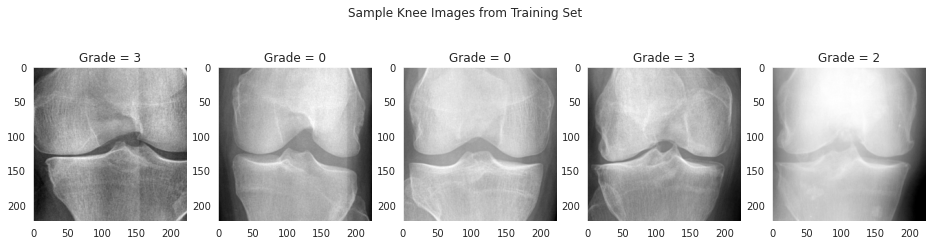

In [27]:
plt.figure(figsize=(16, 4))
for images, labels in train_dataset.take(1):
    for i in range(5):
        ax = plt.subplot(1,5,i+1)
        plt.imshow(images[i].numpy().squeeze().astype('uint8'),cmap='gray')
        ax.set_title('Grade = ' + str(labels[i].numpy()))
_ = plt.suptitle('Sample Knee Images from Training Set')

In [51]:
def plot_distribution(set_of_files, title):
    f, ax = plt.subplots(figsize=(16,6))
    keys = sorted(list(set_of_files.keys()))
    vals = [len(set_of_files[k]) for k in keys]
    sns.barplot(x=keys, y=vals, palette="Blues_d")
    plt.xlabel('Knee Severity Grade')
    plt.title(title)

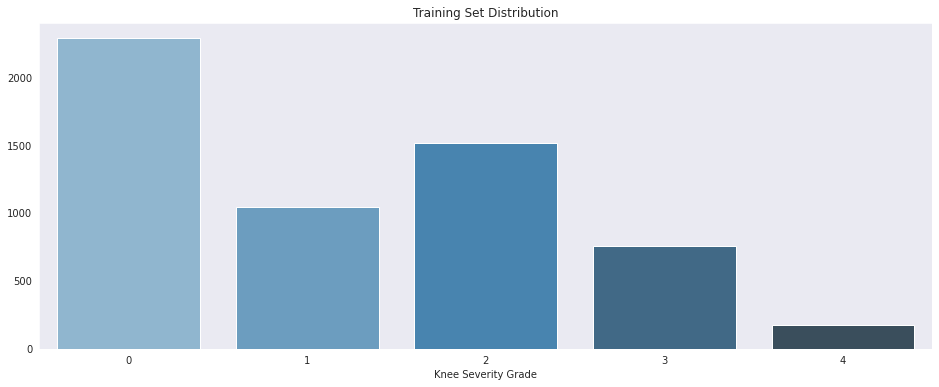

In [52]:
plot_distribution(train_files, 'Training Set Distribution')

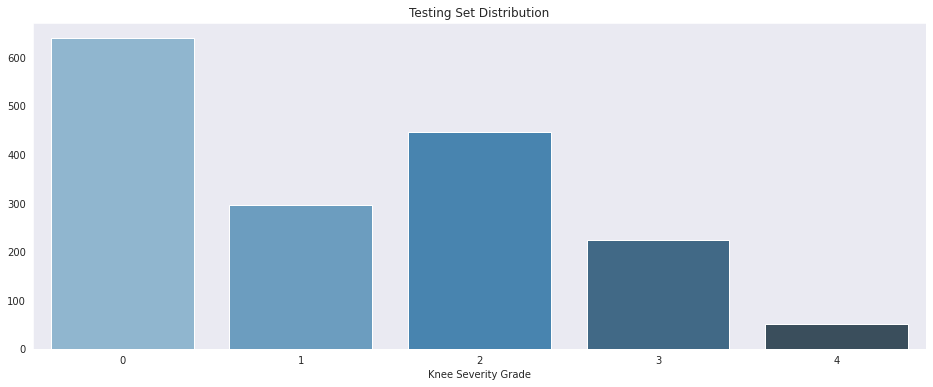

In [53]:
plot_distribution(test_files, 'Testing Set Distribution')

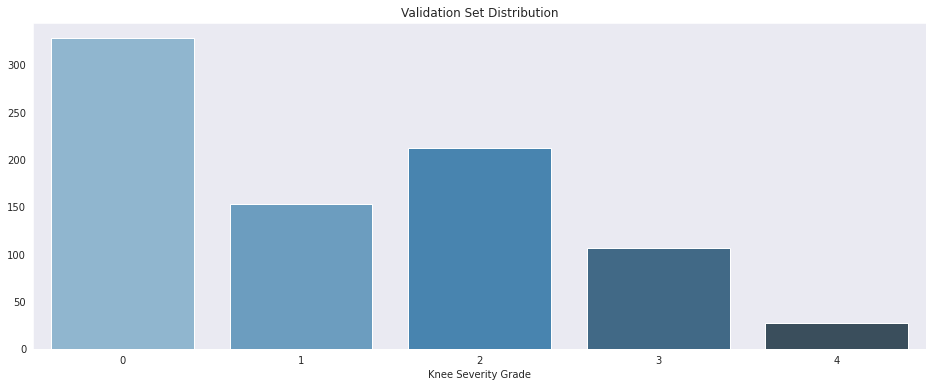

In [54]:
plot_distribution(val_files, 'Validation Set Distribution')

## 4 Model

In [43]:
num_classes = 5

model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(img_height, img_width, 1), padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes))

In [44]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 55, 55, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 96800)             0

In [46]:
num_epochs = 5
history = model.fit(train_dataset, validation_data=val_dataset, epochs=num_epochs)

Epoch 1/5
181/181 [==============================] - 294s 2s/step - loss: 73.0018 - accuracy: 0.3553 - val_loss: 1.5727 - val_accuracy: 0.3971
Epoch 2/5
181/181 [==============================] - 292s 2s/step - loss: 1.4263 - accuracy: 0.3941 - val_loss: 1.5504 - val_accuracy: 0.3971
Epoch 3/5
181/181 [==============================] - 291s 2s/step - loss: 1.4233 - accuracy: 0.3936 - val_loss: 1.5383 - val_accuracy: 0.3959
Epoch 4/5
181/181 [==============================] - 290s 2s/step - loss: 1.4125 - accuracy: 0.3967 - val_loss: 1.5303 - val_accuracy: 0.3838
Epoch 5/5
181/181 [==============================] - 290s 2s/step - loss: 1.4012 - accuracy: 0.3994 - val_loss: 1.5280 - val_accuracy: 0.3838


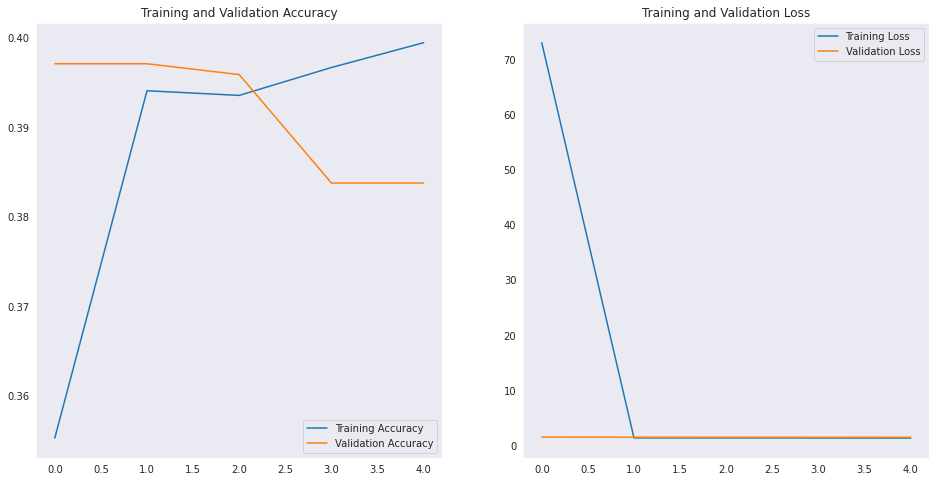

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [48]:
predictions = model.predict(test_dataset, batch_size=32, verbose=1)

52/52 [==============================] - 18s 339ms/step


In [49]:
print(predictions.shape)

(1656, 5)


In [50]:
print(predictions[0])
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(np.argmax(score), 100 * np.max(score))
)

[ 2.2036904e-01  3.1318516e-04  9.1270998e-02 -2.8191842e-02
 -4.2247045e-01]
This image most likely belongs to 0 with a 25.08 percent confidence.
